In [1]:
using DifferentialEquations
using PyCall
import Random
using PyPlot
using Statistics

In [8]:
function KM_model!(du, u, p, t)

    n = length(u)
    for i = 1:n
        sumj = 0.0
        for j = 1:n
            sumj += p[3][i, j] * sin(u[j] - u[i])
        end
        du[i] = p[2][i] + p[1] * sumj
    end

    return du
end

function order(theta)
    
    n = length(theta)
    
    real_R = 0.0
    imag_R = 0.0
    
    for i = 1:n
        real_R += cos(theta[i])
        imag_R += sin(theta[i])
    end
    
    real_R /= n
    imag_R /= n
    r = sqrt(real_R * real_R + imag_R * imag_R)
    
    return r
end

order (generic function with 1 method)

In [15]:
Random.seed!(1234)

K = collect(0:0.1:5)             # coupling
N = 50                          # number of nodes
dt = 0.01                       # time step
T = 2000.0                       # simulation time
T_trans = 0.0                   # transition time
mu = 2.0                        # mean value of initial frequencies
sigma = 0.1                    # std of initial frequencies
p = 0.5                         # probability of connections in random graph
R = zeros(length(K))

nx = pyimport("networkx")
np = pyimport("numpy")

G = nx.gnp_random_graph(N, p, seed=1)
adj = nx.to_numpy_array(G, dtype=np.int)

ind_transition = Int64(T_trans/dt)
theta_0 = rand(N) .* 2.0 .* pi .- pi
omega_0 = randn(N) .* sigma .+ mu 
tspan = (0.0, T)
p = [K[1]/N, omega_0, adj]

for i = 1: length(K)
    p[1] = K[i]/N

    prob = ODEProblem(KM_model!, theta_0, tspan, p)
    sol = solve(prob, saveat=0.01);

    nstep = length(sol.t)
    r = zeros(nstep)

    for j =1:nstep
        r[j] = order(sol.u[j])
    end

    R[i] = mean(r)
#     println("K = ", K[i], " R = ", R[i])
end   

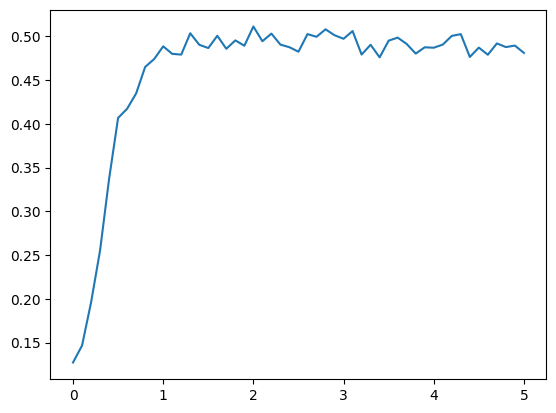

In [16]:
plot(K, R);